In [1]:
# CIL methods
from cil.framework import AcquisitionGeometry, AcquisitionData, DataContainer
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer
from cil.io.utilities import HDF5_utilities
from cil.io import TIFFWriter
from cil.processors import Normaliser, RingRemover, Slicer, TransmissionAbsorptionConverter, CentreOfRotationCorrector, PaganinProcessor
from cil.recon import FBP

# Additional packages
import numpy as np # conda install numpy
import matplotlib.pyplot as plt # conda install matplotlib
import hdf5plugin # conda install -c conda-forge hdf5plugin
from scipy.spatial.transform import Rotation as R
from scripts.HDF5_ParallelDataReader import HDF5_ParallelDataReader

/home/bgb37495/miniconda3/envs/lamino/lib/python3.12/site-packages/dxchange/__init__.py:63: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
filename = '/mnt/share/ALC_laminography/tomobank/brain_x2y1.h5'
HDF5_utilities.print_metadata(filename)

	 - exchange : <HDF5 group "/exchange" (4 members)>
		 - data : <HDF5 dataset "data": shape (2999, 2256, 3232), type "<u2">
		 - data_dark : <HDF5 dataset "data_dark": shape (20, 2256, 3232), type "<u2">
		 - data_white : <HDF5 dataset "data_white": shape (20, 2256, 3232), type "<u2">
		 - theta : <HDF5 dataset "theta": shape (3000,), type "<f4">


In [3]:
HDF5_utilities.get_dataset_metadata(filename, 'exchange/data/')

{'ndim': 3,
 'shape': (2999, 2256, 3232),
 'size': 21866884608,
 'dtype': dtype('uint16'),
 'compression': None,
 'chunks': None,
 'is_virtual': False}

In [4]:
HDF5_utilities.get_dataset_metadata(filename, 'exchange/data_dark/')

{'ndim': 3,
 'shape': (20, 2256, 3232),
 'size': 145827840,
 'dtype': dtype('uint16'),
 'compression': None,
 'chunks': None,
 'is_virtual': False}

In [5]:
HDF5_utilities.get_dataset_metadata(filename, 'exchange/data_white/')

{'ndim': 3,
 'shape': (20, 2256, 3232),
 'size': 145827840,
 'dtype': dtype('uint16'),
 'compression': None,
 'chunks': None,
 'is_virtual': False}

In [6]:
binning = 4

In [7]:
data = HDF5_utilities.read(filename, 'exchange/data/',(slice(0,-1,binning), slice(0,-1,binning), slice(0,-1,binning)))

In [8]:
dark = HDF5_utilities.read(filename, 'exchange/data_dark/',(slice(None), slice(0,-1,binning), slice(0,-1,binning)))

In [9]:
flat = HDF5_utilities.read(filename, 'exchange/data_white/',(slice(None), slice(0,-1,binning), slice(0,-1,binning)))

In [10]:
angles = HDF5_utilities.read(filename, 'exchange/theta/', source_sel=slice(0,-1,binning))

In [11]:
ag = AcquisitionGeometry.create_Parallel3D()
ag.set_angles(angles, angle_unit='radian')
ag.set_panel([data.shape[2], data.shape[1]], pixel_size=0.92)

In [12]:
data = AcquisitionData(data, deep_copy=False, geometry=ag)

In [13]:
flat.mean(axis=0).shape

(564, 808)

In [14]:
data_norm = Normaliser(flat_field=flat.mean(axis=0), dark_field=dark.mean(axis=0))(data)

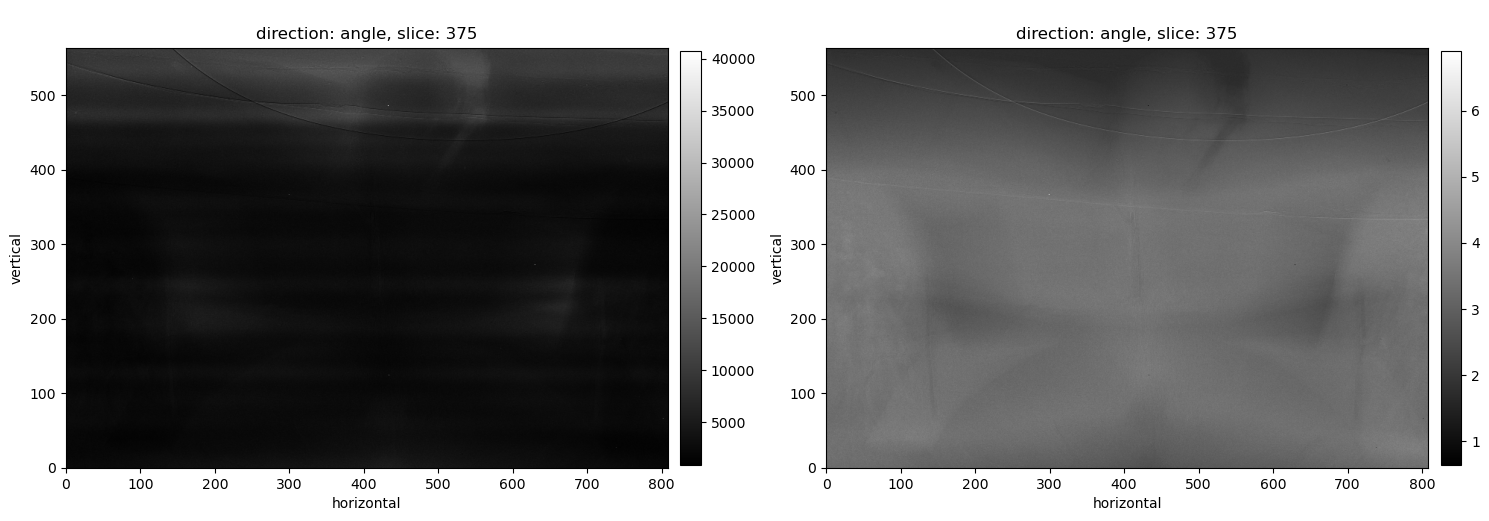

In [15]:
processor = TransmissionAbsorptionConverter(min_intensity=0.001, white_level=data_norm.max())
processor.set_input(data_norm)
processor.get_output(out=data_norm)
show2D([data, data_norm])

In [16]:
tilt = -20
tilt_direction = np.array([1, 0, 0])
untilted_rotation_axis = np.array([0, 0, 1])
rotation_matrix = R.from_rotvec(np.radians(tilt) * tilt_direction)
tilted_rotation_axis = rotation_matrix.apply(untilted_rotation_axis)

ag.config.system.rotation_axis.direction = tilted_rotation_axis

In [17]:
data_norm.reorder('astra')
ag = data_norm.geometry
ig = ag.get_ImageGeometry()

In [18]:
from cil.processors import Padder
data_pad = Padder(mode='constant', pad_width=400)(data_norm)

In [19]:
fbp = FBP(data_pad, ig, backend='astra')
recon = fbp.run(verbose=0)


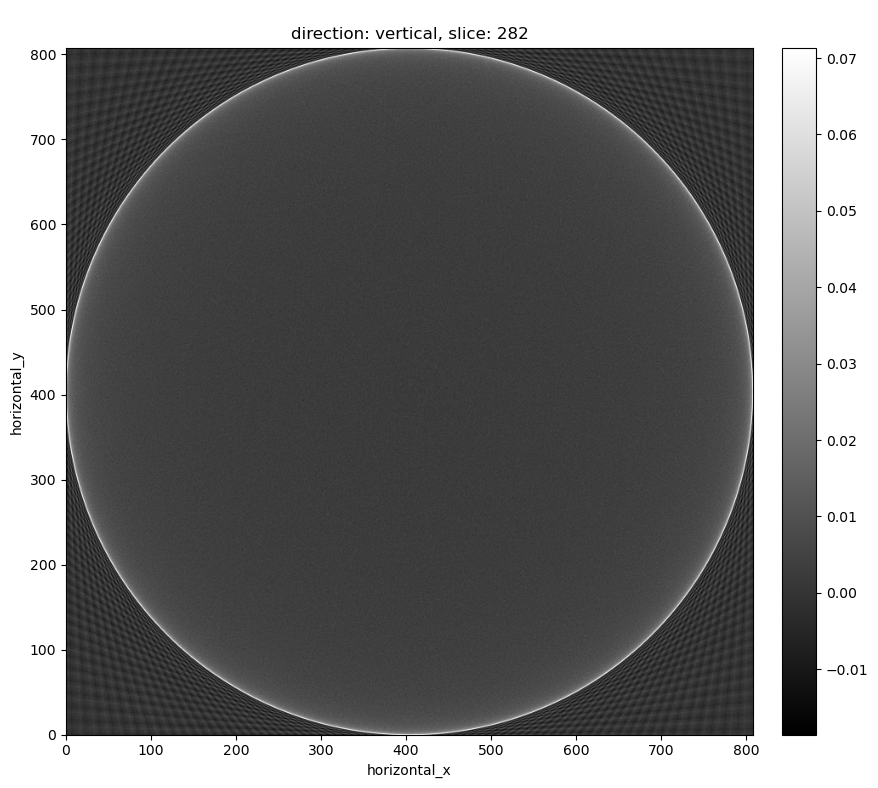

In [20]:
show2D(recon)

In [21]:
islicer(recon)